# Capstone Project - The Battle of the Neighborhoods

### Applied Data Science Capstone by Michael Glazer

## Table of Contents
1. Introduction: Business Problem
2. Data
3. Methodology
4. Analysis
5. Results and Discussion
6. Conclusion

## Introduction: Business Problem
This Capstone project will try to find an optimal apartment for an individual currently residing in The Uptown Residences in Toronto, Canada, looking to move to New York City, New York. Along side the criteria of the specification of the new apartment, this report will attempt to find a home for the individual in a neighborhood similar to the neighborhood they currently reside in (Yorkville). 

Throughout this project we will assume that the individual’s decision to move to New York City is based around a new job in the Financial District. The Financial District is located in the south end of Manhattan, as a result we will attempt to find an apartment to rent within the surrounding neighborhoods of Tribeca, Soho, Bowery and the Lower East Side.

As previously mentioned, the individual is living in The Uptown Residences, they currently rent a 1-bedroom, 1-bathroom apartment. The size of the apartment is 570 sq. ft. and the current rent is $2400. The distance to the nearest subway station is 280m, giving the individual east access to transportation throughout the city. The Yorkville neighborhood is one of Canada’s most exclusive shopping districts, along side the numerous shopping options is bars and restaurants, art galleries, office spaces and parks.

In order to create a similar living environment for the individual in New York City, we must be able to find an apartment located in a similar neighborhood that offers similar characteristics to their current situation. In order to live in close proximity to the Financial District we must find the individual a rental unit with the following conditions:

- An apartment with 1-bedroom, and 1-bathroom.
- The unit must not exceed an increased monthly rent of $3500.
- The apartment must be in a neighborhood near the Financial District.
- Must be in proximity to the subway station.
- The neighborhood must have similar attributes to Yorkville to make the transition to New York as seamless as possible.


## Data

Based on the problem at hand, the factors that would affect the decision are:
- The venues in Yorkville which surrounds The Uptown Residences.
- The venues in the different neighborhoods in Manhattan.
- The location of the subway stations in Manhattan.
- The available apartments that meet the desired criteria.
The geocoders from the geoPy library will be used to generate approximate longitudinal and latitudinal coordinates for:
- The Uptown Residences - 35 Balmuto St, Toronto, ON M4Y 0A3, Canada
- Manhattan, New York
- Apartments for rent in New York

Foursquare API will be used to acquire desired venue data.
The neighborhoods and their corresponding longitudinal and latitudinal coordinates are retrieved from https://cocl.us/new_york_dataset.
The list of new York subway stations and their coordinates was retrieved from https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49. Data cleaning is required to obtain each station name, and their latitude and longitude.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

## Toronto Analysis

In [2]:
addressTO = '35 Balmuto St, Toronto, Canada'
geolocator = Nominatim()
locationTO = geolocator.geocode(addressTO)
latitudeTO = locationTO.latitude
longitudeTO = locationTO.longitude
print('The geograpical coordinate of the Toronto condo is {}, {}.'.format(latitudeTO, longitudeTO))

The geograpical coordinate of the Toronto condo is 43.6694927, -79.3874145473265.


In [3]:
# @hidden_cell
CLIENT_ID = 'ZPVYU5KJINOUDUG2KJUJPSIR4NNOIHI3TTRNURXI0VA30C5C' # your Foursquare ID
CLIENT_SECRET = 'PSC1BRBK4YPKH3W4BRG3HRRAGHXZKMNN1KMMB1PCA5JXBB32' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZPVYU5KJINOUDUG2KJUJPSIR4NNOIHI3TTRNURXI0VA30C5C
CLIENT_SECRET:PSC1BRBK4YPKH3W4BRG3HRRAGHXZKMNN1KMMB1PCA5JXBB32


In [4]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeTO, 
    longitudeTO, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZPVYU5KJINOUDUG2KJUJPSIR4NNOIHI3TTRNURXI0VA30C5C&client_secret=PSC1BRBK4YPKH3W4BRG3HRRAGHXZKMNN1KMMB1PCA5JXBB32&v=20180605&ll=43.6694927,-79.3874145473265&radius=500&limit=100'

In [5]:
# results display is hidden for report simplification 
results = requests.get(url).json()
# results

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items']
    
nearby_venuesTO = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesTO = nearby_venuesTO.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesTO['venue.categories'] = nearby_venuesTO.apply(get_category_type, axis=1)

# clean columns
nearby_venuesTO.columns = [col.split(".")[-1] for col in nearby_venuesTO.columns]

nearby_venuesTO.head(10)

,name,categories,lat,lng
0,Indigo,Bookstore,43.669065,-79.389057
1,Pi Co.,Pizza Place,43.670107,-79.389852
2,Sabai Sabai,Thai Restaurant,43.670647,-79.384857
3,Paramount Fine Foods,Middle Eastern Restaurant,43.670677,-79.389865
4,Toronto Hemp Company,Smoke Shop,43.668419,-79.385848
5,Wish,Restaurant,43.668759,-79.385694
6,Page & Panel: The TCAF Shop,Comic Shop,43.671653,-79.387141
7,Naan & Kabob,Afghan Restaurant,43.669005,-79.386219
8,Planta Yorkville,Vegetarian / Vegan Restaurant,43.670213,-79.389512
9,Starbucks,Coffee Shop,43.669895,-79.388175


In [8]:
mapTo = folium.Map(location=[latitudeTO, longitudeTO], zoom_start=18)
# add markers to map
for lat, lng, label in zip(nearby_venuesTO['lat'], nearby_venuesTO['lng'], nearby_venuesTO['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=10,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(mapTo)  
    
# mapTo  # Uncomment to view map

In [9]:
nearby_venuesTO.count()

name          100
categories    100
lat           100
lng           100
dtype: int64

In [10]:
# define the dataframe columns
column_names = ['City', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
curNeighborhood = pd.DataFrame(columns=column_names)
curNeighborhood

,City,Neighborhood,Latitude,Longitude


In [11]:
curNeighborhood = curNeighborhood.append({'City': 'Toronto',
                                      'Neighborhood': 'Yorkville',
                                      'Latitude': latitudeTO,
                                      'Longitude': longitudeTO}, ignore_index=True)

In [12]:
curNeighborhood

,City,Neighborhood,Latitude,Longitude
0,Toronto,Yorkville,43.669493,-79.387415


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
curNeighborhood_venues = getNearbyVenues(names=curNeighborhood['Neighborhood'],
                                   latitudes=curNeighborhood['Latitude'],
                                   longitudes=curNeighborhood['Longitude']
                                  )

Yorkville


In [15]:
curNeighborhood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Yorkville,43.669493,-79.387415,Indigo,43.669065,-79.389057,Bookstore
1,Yorkville,43.669493,-79.387415,Pi Co.,43.670107,-79.389852,Pizza Place
2,Yorkville,43.669493,-79.387415,Sabai Sabai,43.670647,-79.384857,Thai Restaurant
3,Yorkville,43.669493,-79.387415,Paramount Fine Foods,43.670677,-79.389865,Middle Eastern Restaurant
4,Yorkville,43.669493,-79.387415,Toronto Hemp Company,43.668419,-79.385848,Smoke Shop


In [16]:
curNeighborhood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Yorkville,100,100,100,100,100,100


In [17]:
print('There are {} uniques categories.'.format(len(curNeighborhood_venues['Venue Category'].unique())))

There are 58 uniques categories.


## Analyze Yorkville Venues

In [18]:
# one hot encoding
yorkville_onehot = pd.get_dummies(curNeighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
yorkville_onehot['Neighborhood'] = curNeighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [yorkville_onehot.columns[-1]] + list(yorkville_onehot.columns[:-1])
yorkville_onehot = yorkville_onehot[fixed_columns]

yorkville_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Art Gallery,Asian Restaurant,Bookstore,Boutique,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Theater,Comic Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Electronics Store,Ethiopian Restaurant,French Restaurant,Furniture / Home Store,Gastropub,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,New American Restaurant,Nightclub,Persian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Shopping Mall,Smoke Shop,Spa,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Women's Store,Yoga Studio
0,Yorkville,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Yorkville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Yorkville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Yorkville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Yorkville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [19]:
yorkville_onehot.shape

(100, 59)

In [20]:
yorkville_grouped = yorkville_onehot.groupby('Neighborhood').mean().reset_index()
yorkville_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Art Gallery,Asian Restaurant,Bookstore,Boutique,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Theater,Comic Shop,Cosmetics Shop,Dance Studio,Deli / Bodega,Diner,Electronics Store,Ethiopian Restaurant,French Restaurant,Furniture / Home Store,Gastropub,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,New American Restaurant,Nightclub,Persian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Shopping Mall,Smoke Shop,Spa,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Women's Store,Yoga Studio
0,Yorkville,0.01,0.01,0.01,0.01,0.01,0.03,0.02,0.01,0.06,0.01,0.02,0.07,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.04,0.01,0.03,0.04,0.03,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.04,0.01,0.01,0.01,0.02,0.04,0.01,0.01,0.01,0.01,0.01,0.03,0.02


In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sortedTO = pd.DataFrame(columns=columns)
neighborhoods_venues_sortedTO['Neighborhood'] = yorkville_grouped['Neighborhood']

for ind in np.arange(yorkville_grouped.shape[0]):
    neighborhoods_venues_sortedTO.iloc[ind, 1:] = return_most_common_venues(yorkville_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sortedTO.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Yorkville,Coffee Shop,Café,Sushi Restaurant,Italian Restaurant,Restaurant,Hotel,Indian Restaurant,Japanese Restaurant,Boutique,Women's Store


## New York Analysis

In [23]:
with open('data/newyork_data.json') as json_data:
    ny_data = json.load(json_data)

nyNHB_data = ny_data['features']

In [24]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyNHB_df = pd.DataFrame(columns=column_names)

In [25]:
for data in nyNHB_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyNHB_df = nyNHB_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
nyNHB_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [26]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyNHB_df['Borough'].unique()),
        nyNHB_df.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [27]:
manhattan_data = nyNHB_df[nyNHB_df['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [28]:
address = 'Bowery, NY'

geolocator = Nominatim(user_agent="ny_explorer")
bowery_location = geolocator.geocode(address)
bowery_latitude = bowery_location.latitude
bowery_longitude = bowery_location.longitude
print('The geograpical coordinate of Bowery are {}, {}.'.format(bowery_latitude, bowery_longitude))
manhattan_data = manhattan_data.append({'Borough': 'Manhattan',
                                          'Neighborhood': 'Bowery',
                                          'Latitude': bowery_latitude,
                                          'Longitude': bowery_longitude}, ignore_index=True)
manhattan_data.tail()

The geograpical coordinate of Bowery are 40.7172381, -73.9954766.


,Borough,Neighborhood,Latitude,Longitude
36,Manhattan,Tudor City,40.746917,-73.971219
37,Manhattan,Stuyvesant Town,40.731000,-73.974052
38,Manhattan,Flatiron,40.739673,-73.990947
39,Manhattan,Hudson Yards,40.756658,-74.000111
40,Manhattan,Bowery,40.717238,-73.995477


In [29]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [30]:
# @hidden_cell
CLIENT_ID = 'ZPVYU5KJINOUDUG2KJUJPSIR4NNOIHI3TTRNURXI0VA30C5C' # your Foursquare ID
CLIENT_SECRET = 'PSC1BRBK4YPKH3W4BRG3HRRAGHXZKMNN1KMMB1PCA5JXBB32' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZPVYU5KJINOUDUG2KJUJPSIR4NNOIHI3TTRNURXI0VA30C5C
CLIENT_SECRET:PSC1BRBK4YPKH3W4BRG3HRRAGHXZKMNN1KMMB1PCA5JXBB32


In [31]:
soho_index = manhattan_data.index[manhattan_data['Neighborhood'] == 'Soho'].tolist()[0]
Tribeca_index = manhattan_data.index[manhattan_data['Neighborhood'] == 'Tribeca'].tolist()[0]
Bowery_index = manhattan_data.index[manhattan_data['Neighborhood'] == 'Bowery'].tolist()[0]
Lower_East_Side_index = manhattan_data.index[manhattan_data['Neighborhood'] == 'Lower East Side'].tolist()[0]
soho_index, Tribeca_index, Bowery_index, Lower_East_Side_index

(23, 21, 40, 20)

In [32]:
manhattan_data.iloc[[soho_index]]

,Borough,Neighborhood,Latitude,Longitude
23,Manhattan,Soho,40.722184,-74.000657


In [33]:
desired_neigh_index = [soho_index, Tribeca_index, Bowery_index, Lower_East_Side_index]
spec_manhattan_data = manhattan_data.loc[desired_neigh_index].reset_index(drop=True)
spec_manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Soho,40.722184,-74.000657
1,Manhattan,Tribeca,40.721522,-74.010683
2,Manhattan,Bowery,40.717238,-73.995477
3,Manhattan,Lower East Side,40.717807,-73.980890


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
manhattan_venues = getNearbyVenues(names=spec_manhattan_data['Neighborhood'],
                                   latitudes=spec_manhattan_data['Latitude'],
                                   longitudes=spec_manhattan_data['Longitude']
                                  )

Soho
Tribeca
Bowery
Lower East Side


In [36]:
print(manhattan_venues.shape)
manhattan_venues.head()

(360, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Soho,40.722184,-74.000657,Sam Brocato Salon,40.722371,-74.002562,Salon / Barbershop
1,Soho,40.722184,-74.000657,Dance With Me SoHo,40.722578,-74.001363,Dance Studio
2,Soho,40.722184,-74.000657,Purl Soho,40.722326,-74.000994,Arts & Crafts Store
3,Soho,40.722184,-74.000657,SoulCycle SoHo,40.721899,-73.998717,Cycle Studio
4,Soho,40.722184,-74.000657,MUJI 無印良品 (MUJI),40.720709,-74.001015,Miscellaneous Shop


In [37]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bowery,100,100,100,100,100,100
Lower East Side,60,60,60,60,60,60
Soho,100,100,100,100,100,100
Tribeca,100,100,100,100,100,100


In [38]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 134 uniques categories.


In [39]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Animal Shelter,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Auto Workshop,Bagel Shop,Bakery,Basketball Court,Beer Garden,Bike Rental / Bike Share,Bike Shop,Boutique,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Filipino Restaurant,French Restaurant,Furniture / Home Store,Garden Center,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,High School,History Museum,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Park,Performing Arts Venue,Pet Café,Pharmacy,Pilates Studio,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Restaurant,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Skate Park,Ski Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Soho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Soho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Soho,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Soho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Soho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
manhattan_onehot.shape

(360, 135)

In [41]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,American Restaurant,Animal Shelter,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Auto Workshop,Bagel Shop,Bakery,Basketball Court,Beer Garden,Bike Rental / Bike Share,Bike Shop,Boutique,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Filipino Restaurant,French Restaurant,Furniture / Home Store,Garden Center,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,High School,History Museum,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Park,Performing Arts Venue,Pet Café,Pharmacy,Pilates Studio,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Restaurant,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Skate Park,Ski Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bowery,0.00,0.01,0.01,0.000000,0.010000,0.00,0.00,0.01,0.00,0.000000,0.010000,0.040000,0.00,0.01,0.000000,0.01,0.00,0.00,0.01,0.010000,0.00,0.02,0.070000,0.000000,0.060000,0.02,0.000000,0.01,0.00,0.00,0.000000,0.010000,0.00,0.020000,0.01,0.000000,0.00,0.04,0.00,0.01,0.00,0.00,0.000000,0.000000,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.01,0.020000,0.00,0.00,0.00,0.01,0.02,0.00,0.03,0.040000,0.00,0.00,0.00,0.010000,0.010000,0.01,0.000000,0.00,0.000000,0.00,0.03,0.00,0.02,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.04,0.02,0.000000,0.000000,0.000000,0.010000,0.00,0.01,0.00,0.00,0.00,0.01,0.000000,0.010000,0.01,0.01,0.00,0.03,0.030000,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.020000,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.02,0.000000,0.000000,0.000000,0.00,0.00,0.030000,0.00,0.00,0.00,0.02,0.00,0.000000,0.010000
1,Lower East Side,0.00,0.00,0.00,0.016667,0.033333,0.00,0.00,0.00,0.00,0.016667,0.016667,0.033333,0.00,0.00,0.016667,0.00,0.00,0.00,0.00,0.016667,0.00,0.05,0.033333,0.016667,0.033333,0.05,0.016667,0.00,0.00,0.00,0.016667,0.016667,0.00,0.016667,0.00,0.016667,0.00,0.00,0.00,0.00,0.00,0.00,0.016667,0.016667,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.016667,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.016667,0.00,0.00,0.00,0.016667,0.033333,0.00,0.016667,0.00,0.016667,0.00,0.00,0.00,0.00,0.016667,0.00,0.00,0.00,0.00,0.00,0.00,0.016667,0.00,0.016667,0.00,0.00,0.033333,0.016667,0.016667,0.016667,0.00,0.05,0.00,0.00,0.00,0.05,0.016667,0.016667,0.00,0.00,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.016667,0.00,0.00,0.00,0.00,0.016667,0.00,0.00,0.00,0.016667,0.016667,0.016667,0.00,0.00,0.016667,0.00,0.00,0.00,0.00,0.00,0.016667,0.016667
2,Soho,0.01,0.02,0.00,0.000000,0.030000,0.01,0.01,0.00,0.01,0.000000,0.000000,0.030000,0.00,0.00,0.000000,0.00,0.06,0.01,0.00,0.010000,0.00,0.02,0.000000,0.090000,0.000000,0.01,0.000000,0.00,0.01,0.01,0.010000,0.000000,0.02,0.020000,0.00,0.000000,0.00,0.00,0.01,0.00,0.00,0.01,0.000000,0.020000,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.01,0.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sortedNY = pd.DataFrame(columns=columns)
neighborhoods_venues_sortedNY['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sortedNY.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sortedNY.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bowery,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Dumpling Restaurant,Noodle House,Bakery,Hotpot Restaurant,Vietnamese Restaurant,Salon / Barbershop,Sandwich Place
1,Lower East Side,Café,Ramen Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Cocktail Bar,Park,Japanese Restaurant,Chinese Restaurant,Art Gallery
2,Soho,Clothing Store,Boutique,Shoe Store,Women's Store,Italian Restaurant,Bakery,Sporting Goods Shop,Mediterranean Restaurant,Art Gallery,Men's Store
3,Tribeca,Spa,Italian Restaurant,Park,Café,Boutique,American Restaurant,Gym,Coffee Shop,Wine Bar,Greek Restaurant


In [44]:
# set number of clusters
kclusters = 1

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0], dtype=int32)

In [45]:
# add clustering labels
neighborhoods_venues_sortedNY.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = spec_manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sortedNY.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Soho,40.722184,-74.000657,0,Clothing Store,Boutique,Shoe Store,Women's Store,Italian Restaurant,Bakery,Sporting Goods Shop,Mediterranean Restaurant,Art Gallery,Men's Store
1,Manhattan,Tribeca,40.721522,-74.010683,0,Spa,Italian Restaurant,Park,Café,Boutique,American Restaurant,Gym,Coffee Shop,Wine Bar,Greek Restaurant
2,Manhattan,Bowery,40.717238,-73.995477,0,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Dumpling Restaurant,Noodle House,Bakery,Hotpot Restaurant,Vietnamese Restaurant,Salon / Barbershop,Sandwich Place
3,Manhattan,Lower East Side,40.717807,-73.980890,0,Café,Ramen Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Cocktail Bar,Park,Japanese Restaurant,Chinese Restaurant,Art Gallery


In [46]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Soho,Clothing Store,Boutique,Shoe Store,Women's Store,Italian Restaurant,Bakery,Sporting Goods Shop,Mediterranean Restaurant,Art Gallery,Men's Store
1,Tribeca,Spa,Italian Restaurant,Park,Café,Boutique,American Restaurant,Gym,Coffee Shop,Wine Bar,Greek Restaurant
2,Bowery,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Dumpling Restaurant,Noodle House,Bakery,Hotpot Restaurant,Vietnamese Restaurant,Salon / Barbershop,Sandwich Place
3,Lower East Side,Café,Ramen Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Cocktail Bar,Park,Japanese Restaurant,Chinese Restaurant,Art Gallery


## Comparing the New York Neighborhoods to Yorkville

In [47]:
neighborhoods_venues_sortedTO.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Yorkville,Coffee Shop,Café,Sushi Restaurant,Italian Restaurant,Restaurant,Hotel,Indian Restaurant,Japanese Restaurant,Boutique,Women's Store


In [48]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Soho,Clothing Store,Boutique,Shoe Store,Women's Store,Italian Restaurant,Bakery,Sporting Goods Shop,Mediterranean Restaurant,Art Gallery,Men's Store
1,Tribeca,Spa,Italian Restaurant,Park,Café,Boutique,American Restaurant,Gym,Coffee Shop,Wine Bar,Greek Restaurant
2,Bowery,Chinese Restaurant,Cocktail Bar,Ice Cream Shop,Dumpling Restaurant,Noodle House,Bakery,Hotpot Restaurant,Vietnamese Restaurant,Salon / Barbershop,Sandwich Place
3,Lower East Side,Café,Ramen Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Cocktail Bar,Park,Japanese Restaurant,Chinese Restaurant,Art Gallery


## Subway Stations in the New Work Neighborhoods

In [49]:
# from https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49 a csv file of the new york subway stations was downloaded
headers = ['Station Name', 'Neighborhood', 'Latitude', 'Longitude']
filename = 'data/NY Subway Stations.csv'
nyMetro_df = pd.read_csv(filename, names = headers, skiprows = 1)
nyMetro_df = nyMetro_df.dropna().reset_index(drop = True)
nyMetro_df

,Station Name,Neighborhood,Latitude,Longitude
0,Delancey St - Essex St,Lower East Side,40.718306,-73.987409
1,East Broadway,Lower East Side,40.713855,-73.990177
2,Lower East Side - 2nd Ave,Lower East Side,40.723402,-73.989938
3,Spring St,Soho,40.726227,-74.003739
4,Prince St,Soho,40.724329,-73.997702
5,World Trade Center,Tribeca,40.712564,-74.009745
6,Chambers St,Tribeca,40.713234,-74.003407
7,Canal St,Soho,40.718174,-73.999826
8,Broadway - Lafayette St,Lower East Side,40.725297,-73.996204
9,Bowery,Bowery,40.720247,-73.993807


In [50]:
headers = ['Address', 'Latitude', 'Longitude', 'Price', 'Size', 'Rooms']
filename = 'data/triNYRent_data.csv'
triNY_rent = pd.read_csv(filename, names = headers, skiprows = 1)
triNY_rent

,Address,Latitude,Longitude,Price,Size,Rooms
0,310 Greenwich St,NaN,NaN,3195,550,1
1,30 Harrison St,NaN,NaN,3000,500,1
2,149 Franklin St,NaN,NaN,3500,850,2
3,77 Hudson St,NaN,NaN,2900,715,1
4,121-133 Reade St,NaN,NaN,3395,600,1


In [51]:
pd.options.mode.chained_assignment = None
for i in range(len(triNY_rent)):
    address = (triNY_rent['Address'][i] + ',' + ' Manhattan NY') 
    geolocator = Nominatim() 
    location = geolocator.geocode(address) 
    latitude = location.latitude 
    longitude = location.longitude 

    triNY_rent['Latitude'][i] = latitude 
    triNY_rent['Longitude'][i] = longitude
triNY_rent

,Address,Latitude,Longitude,Price,Size,Rooms
0,310 Greenwich St,40.716817,-74.010967,3195,550,1
1,30 Harrison St,40.718790,-74.009476,3000,500,1
2,149 Franklin St,40.719003,-74.007757,3500,850,2
3,77 Hudson St,40.718469,-74.009101,2900,715,1
4,121-133 Reade St,40.716180,-74.009400,3395,600,1


In [52]:
headers = ['Borough', 'Neighborhood', 'Median Rent']
filename = 'data/manhattanRentData.csv'
nyRentData = pd.read_csv(filename, names = headers, skiprows = 1)
nyRentData.head()

,Borough,Neighborhood,Median Rent
0,Queens,Astoria,1650
1,Manhattan,Battery Park City,3170
2,Brooklyn,Bay Ridge,1450
3,Bronx,Bedford Park,1325
4,Brooklyn,Bedford-Stuyvesant,1875


In [53]:
manRentData = nyRentData[nyRentData['Borough'] == 'Manhattan'].reset_index(drop = True)
manRentData.head()

,Borough,Neighborhood,Median Rent
0,Manhattan,Battery Park City,3170
1,Manhattan,Central Harlem,1797
2,Manhattan,Central Park South,3300
3,Manhattan,Chelsea,3000
4,Manhattan,Chinatown,1996


In [54]:
nyRentData.shape

(104, 3)

In [55]:
nyRent1 = nyRentData[nyRentData['Median Rent'] < 1500].reset_index(drop = True)
nyRent1.head()

,Borough,Neighborhood,Median Rent
0,Brooklyn,Bay Ridge,1450
1,Bronx,Bedford Park,1325
2,Queens,Briarwood,1445
3,Bronx,Bronx,1475
4,Bronx,Castle Hill,1325


In [56]:
nyRent2 = nyRentData[(nyRentData['Median Rent'] >= 1500) & (nyRentData['Median Rent'] < 2000)].reset_index(drop = True)
nyRent2.head()

,Borough,Neighborhood,Median Rent
0,Queens,Astoria,1650
1,Brooklyn,Bedford-Stuyvesant,1875
2,Brooklyn,Bensonhurst,1765
3,Brooklyn,Boerum Hill,1977
4,Brooklyn,Borough Park,1875


In [57]:
nyRent3 = nyRentData[(nyRentData['Median Rent'] >= 2000) & (nyRentData['Median Rent'] < 2500)].reset_index(drop = True)
nyRent3.head()

,Borough,Neighborhood,Median Rent
0,Brooklyn,Brooklyn,2175
1,Brooklyn,Brooklyn Heights,2350
2,Brooklyn,Bushwick,2050
3,Brooklyn,Carroll Gardens,2238
4,Brooklyn,Clinton Hill,2050


In [58]:
nyRent4 = nyRentData[(nyRentData['Median Rent'] >= 2500) & (nyRentData['Median Rent'] < 3000)].reset_index(drop = True)
nyRent4.head()

,Borough,Neighborhood,Median Rent
0,Brooklyn,Downtown Brooklyn,2707
1,Brooklyn,Fort Greene,2590
2,Brooklyn,Gowanus,2557
3,Manhattan,Gramercy Park,2838
4,Brooklyn,Greenpoint,2525


In [59]:
nyRent5 = nyRentData[(nyRentData['Median Rent'] >= 3000) & (nyRentData['Median Rent'] < 3500)].reset_index(drop = True)
nyRent5.head()

,Borough,Neighborhood,Median Rent
0,Manhattan,Battery Park City,3170
1,Manhattan,Central Park South,3300
2,Manhattan,Chelsea,3000
3,Brooklyn,DUMBO,3158
4,Manhattan,Financial District,3100


In [60]:
nyRent6 = nyRentData[(nyRentData['Median Rent'] >= 3500)].reset_index(drop = True)
nyRent6.head()

,Borough,Neighborhood,Median Rent
0,Brooklyn,Red Hook,3500
1,Manhattan,Tribeca,3663


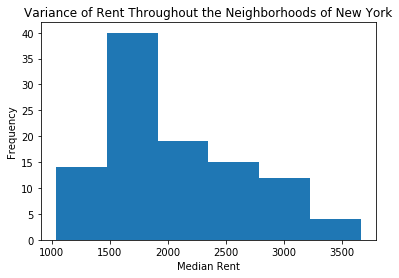

In [67]:
ax = nyRentData.hist(column='Median Rent', grid=False, bins=6)

ax = ax[0]
for x in ax:
    x.set_xlabel('Median Rent')
    x.set_ylabel('Frequency')
    x.set_title('Variance of Rent Throughout the Neighborhoods of New York')

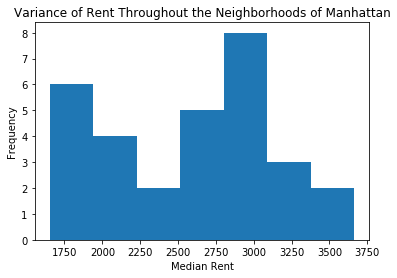

In [62]:
ax = manRentData.hist(column='Median Rent', grid=False, bins=7)

ax = ax[0]
for x in ax:
    x.set_xlabel('Median Rent')
    x.set_ylabel('Frequency')
    x.set_title('Variance of Rent Throughout the Neighborhoods of Manhattan')

In [63]:
addressTri = 'Tribeca, New York'
geolocator = Nominatim()
locationTri = geolocator.geocode(addressTri)
latitudeTri = locationTri.latitude
longitudeTri = locationTri.longitude
print('The geograpical coordinate of Tribeca is {}, {}.'.format(latitudeTri, longitudeTri))

The geograpical coordinate of Tribeca is 40.7153802, -74.0093063.


In [66]:
tribecaRentMap = folium.Map(location = [latitudeTri, longitudeTri], zoom_start = 16)

# add markers to map
for lat, lng, label in zip(triNY_rent['Latitude'], triNY_rent['Longitude'],'$ ' + triNY_rent['Price'].astype(str)+ ',  '+ triNY_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tribecaRentMap) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(nyMetro_df['Latitude'], nyMetro_df['Longitude'],  nyMetro_df['Station Name'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(tribecaRentMap) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
tribecaRentMap.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(tribecaRentMap)

tribecaRentMap

From the map we see that the appartment at 149 Franklin is the closest to a subway stop with a distance of 75m, making this appartment the most desirbale.